In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from nice.algorithms.connectivity import epochs_compute_wsmi_dropped
import mne
import warnings
warnings.filterwarnings("ignore")
# mne.set_log_level('WARNING')
from scipy.ndimage import gaussian_filter1d


def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds.astype(float) > 1e-6    #finds the time points where std is not 0
    const_cols = stds.astype(float) <= 1e-6    #finds the time points where std is 0

    z = np.zeros_like(data[:, :])   #creates an array of zeros with the same shape as the data
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)  #in the columns where std is not 0, zscores the data
    z[:, const_cols] = np.mean(data[:, const_cols], axis=0)

 
    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

wsmi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
wsmi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}

total_time = time.time()
def full_wsmi_calc(sigma = 2):
    for file_number in  file_numbers:
        file_total = time.time()
        file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
        load_data_start_time = time.time()
        data = pickle.load(open(file_path, 'rb'))
        elapsed_time = time.time() - load_data_start_time
        print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")


        attention_labels = data['label_attend'][0]
        label_left = data['label_left'][0]
        label_right = data['label_right'][0]
        attend_01 = data['attend'][0]
        omitted = data['omit'][0]
        relevant = np.where(omitted ==0)[0]
    
        left_input_SP = data['SP'][0][0][relevant]
        right_input_SP = data['SP'][0][1][relevant]
        attention_SP = data['SP'][0][2][relevant]

        left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
        right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
        att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

        num_trials, num_samples, num_neurons = left_input_SP.shape
        num_neurons_attention = 80

                
        for j in range(0, num_trials):
            for i in range(0, num_neurons):
                count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
                if count_left > 0:
                    left_sm[j, :, i] /= count_left
                count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
                if count_right > 0:
                    right_sm[j, :, i] /= count_right


            for i in range(0, num_neurons_attention):
                count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
                if count_attention > 0:
                    att_sm[j, :, i] /= count_attention


        left_input_SP = np.sum(left_sm, axis=2)
        right_input_SP = np.sum(right_sm, axis=2)
        attention_SP = np.sum(att_sm, axis=2)

        left_input_SP = preprocess(left_input_SP)
        right_input_SP = preprocess(right_input_SP)
        attention_SP = preprocess(attention_SP)

        #preprocess here now that we have traces of all of the relavant trials
        left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
        _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
        right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
        _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

        #splitting left and right
        left_input_SP_attleft = left_input_SP[left_indices, 100:350]
        right_input_SP_attleft = right_input_SP[left_indices, 100:350]
        attention_SP_attleft = attention_SP[left_indices, 100:350]

        left_input_SP_attright = left_input_SP[right_indices, 100:350]
        right_input_SP_attright = right_input_SP[right_indices, 100:350]
        attention_SP_attright = attention_SP[right_indices, 100:350]


        #----------------------------------------------------------------
        sfreq = 500.0
        ch_names = ['left_input', 'right_input', 'attention_layer']
        ch_types = ['eeg', 'eeg', 'eeg']
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


        data_left = np.stack([
            left_input_SP_attleft, 
            right_input_SP_attleft, 
            attention_SP_attleft 
        ], axis=1) 
        print(data_left.shape)

        epochs_left = mne.EpochsArray(
            data_left,
            info, 
            tmin=0, 
            baseline=None
        )

        data_right = np.stack([
            left_input_SP_attright,
            right_input_SP_attright,
            attention_SP_attright
        ], axis=1) 

        epochs_right = mne.EpochsArray(
            data_right,
            info,
            tmin=0,
            baseline=None
        )
    
        kernel = 3
        taus   = list(range(4, 129, 8))
        wsmi_results = {'left':{}, 'right':{}}

        for tau in taus:
            tau_samples = int(tau / (1000/sfreq))
            wsmi_results['left'][tau], *_ = epochs_compute_wsmi_dropped(
                epochs_left, kernel=kernel, tau=tau_samples,
                backend='python', method_params={'bypass_csd':True}
            )
            wsmi_results['right'][tau], *_ = epochs_compute_wsmi_dropped(
                epochs_right, kernel=kernel, tau=tau_samples,
                backend='python', method_params={'bypass_csd':True}
            )


        for tau in taus:
            wsmi_means[f'dataset_{file_number}']['left_attleft'].append(np.mean(wsmi_results['left'][tau][0, 2, :]))
            wsmi_means[f'dataset_{file_number}']['right_attleft'].append(np.mean(wsmi_results['left'][tau][1, 2, :]))
            wsmi_means[f'dataset_{file_number}']['left_attright'].append(np.mean(wsmi_results['right'][tau][0, 2, :]))
            wsmi_means[f'dataset_{file_number}']['right_attright'].append(np.mean(wsmi_results['right'][tau][1, 2, :]))

            wsmi_stdevs[f'dataset_{file_number}']['left_attleft'].append(np.std(wsmi_results['left'][tau][0, 2, :], ddof = 1))
            wsmi_stdevs[f'dataset_{file_number}']['right_attleft'].append(np.std(wsmi_results['left'][tau][1, 2, :], ddof = 1))
            wsmi_stdevs[f'dataset_{file_number}']['left_attright'].append(np.std(wsmi_results['right'][tau][0, 2, :], ddof = 1))
            wsmi_stdevs[f'dataset_{file_number}']['right_attright'].append(np.std(wsmi_results['right'][tau][1, 2, :], ddof = 1))

    
        del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
        gc.collect()
        del(data)
        gc.collect()
        print(f'Dataset {file_number} complete in', time.time() - file_total)
        print('file progress =', file_number / len(file_numbers) * 100, '%')

    print('total time elapsed =', time.time() - total_time)


In [4]:
full_wsmi_calc(sigma = 2)

Dataset 1 loaded in 9.90 seconds
(495, 3, 250)
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with pytho

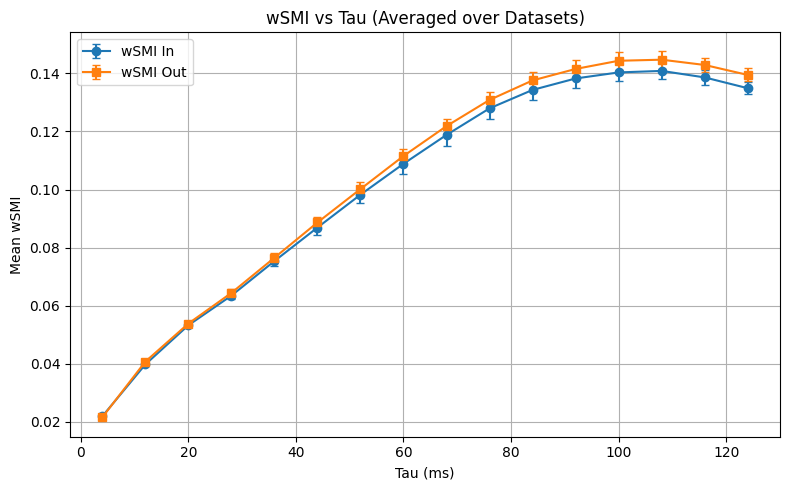

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Use the same taus as in your analysis
taus = list(range(4, 129, 8))
taus_labels = taus  # or convert to ms if needed

# Prepare arrays for means and errors
wsmi_in_means = []
wsmi_in_stds = []
wsmi_out_means = []
wsmi_out_stds = []

for tau_idx, tau in enumerate(taus):
    # For each tau, collect wSMI across datasets
    in_vals = [wsmi_means[f'dataset_{file_number}']['left_attleft'][tau_idx] + wsmi_means[f'dataset_{file_number}']['right_attright'][tau_idx] for file_number in file_numbers]
    out_vals = [wsmi_means[f'dataset_{file_number}']['left_attright'][tau_idx] + wsmi_means[f'dataset_{file_number}']['right_attleft'][tau_idx] for file_number in file_numbers]
    # Average the two conditions for in and out
    in_vals = [v/2 for v in in_vals]
    out_vals = [v/2 for v in out_vals]
    wsmi_in_means.append(np.mean(in_vals))
    wsmi_in_stds.append(np.std(in_vals, ddof=1) / np.sqrt(len(in_vals)))
    wsmi_out_means.append(np.mean(out_vals))
    wsmi_out_stds.append(np.std(out_vals, ddof=1) / np.sqrt(len(out_vals)))

plt.figure(figsize=(8,5))
plt.errorbar(taus_labels, wsmi_in_means, yerr=wsmi_in_stds, label='wSMI In', marker='o', capsize=3)
plt.errorbar(taus_labels, wsmi_out_means, yerr=wsmi_out_stds, label='wSMI Out', marker='s', capsize=3)
plt.xlabel('Tau (ms)')
plt.ylabel('Mean wSMI')
plt.title('wSMI vs Tau (Averaged over Datasets)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]


smi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
smi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")


    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
 
    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80

            
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #preprocess here now that we have traces of all of the relavant trials
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    #splitting left and right
    left_input_SP_attleft = left_input_SP[left_indices, 100:350]
    right_input_SP_attleft = right_input_SP[left_indices, 100:350]
    attention_SP_attleft = attention_SP[left_indices, 100:350]

    left_input_SP_attright = left_input_SP[right_indices, 100:350]
    right_input_SP_attright = right_input_SP[right_indices, 100:350]
    attention_SP_attright = attention_SP[right_indices, 100:350]


    #----------------------------------------------------------------
    sfreq = 500.0
    ch_names = ['left_input', 'right_input', 'attention_layer']
    ch_types = ['eeg', 'eeg', 'eeg']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


    data_left = np.stack([
        left_input_SP_attleft, 
        right_input_SP_attleft, 
        attention_SP_attleft 
    ], axis=1) 
    print(data_left.shape)

    epochs_left = mne.EpochsArray(
        data_left,
        info, 
        tmin=0, 
        baseline=None
    )

    data_right = np.stack([
        left_input_SP_attright,
        right_input_SP_attright,
        attention_SP_attright
    ], axis=1) 

    epochs_right = mne.EpochsArray(
        data_right,
        info,
        tmin=0,
        baseline=None
    )
  
    kernel = 3
    taus   = list(range(4, 129, 8))
    smi_results = {'left':{}, 'right':{}}

    for tau in taus:
        tau_samples = int(tau / (1000/sfreq))
        _, smi_results['left'][tau], _, _ = epochs_compute_wsmi_dropped(
            epochs_left, kernel=kernel, tau=tau_samples,
            backend='python', method_params={'bypass_csd':True}
        )
        _, smi_results['right'][tau], _, _ = epochs_compute_wsmi_dropped(
            epochs_right, kernel=kernel, tau=tau_samples,
            backend='python', method_params={'bypass_csd':True}
        )


    for tau in taus:
        smi_means[f'dataset_{file_number}']['left_attleft'].append(np.mean(smi_results['left'][tau][0, 2, :]))
        smi_means[f'dataset_{file_number}']['right_attleft'].append(np.mean(smi_results['left'][tau][1, 2, :]))
        smi_means[f'dataset_{file_number}']['left_attright'].append(np.mean(smi_results['right'][tau][0, 2, :]))
        smi_means[f'dataset_{file_number}']['right_attright'].append(np.mean(smi_results['right'][tau][1, 2, :]))

        smi_stdevs[f'dataset_{file_number}']['left_attleft'].append(np.std(smi_results['left'][tau][0, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['right_attleft'].append(np.std(smi_results['left'][tau][1, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['left_attright'].append(np.std(smi_results['right'][tau][0, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['right_attright'].append(np.std(smi_results['right'][tau][1, 2, :], ddof = 1))


  
    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)
   

print('total time elapsed =', time.time() - total_time)


Dataset 1 loaded in 7.62 seconds
(495, 3, 250)
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with python...
Cannot autodetect number of jobs
Bypassing CSD
Performing symbolic transformation
Running wsmi with pytho

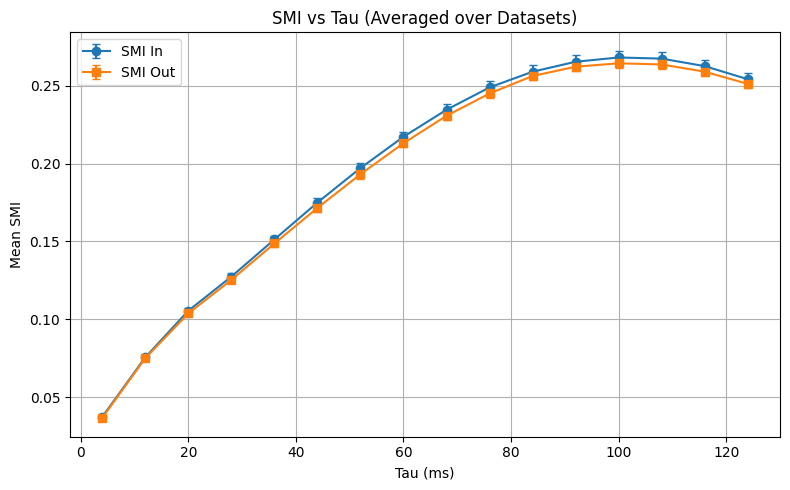

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Use the same taus as in your analysis
taus = list(range(4, 129, 8))
taus_labels = taus  # or convert to ms if needed

# Prepare arrays for means and errors
smi_in_means = []
smi_in_stds = []
smi_out_means = []
smi_out_stds = []

for tau_idx, tau in enumerate(taus):
    # For each tau, collect SMI across datasets
    in_vals = [smi_means[f'dataset_{file_number}']['left_attleft'][tau_idx] + smi_means[f'dataset_{file_number}']['right_attright'][tau_idx] for file_number in file_numbers]
    out_vals = [smi_means[f'dataset_{file_number}']['left_attright'][tau_idx] +smi_means[f'dataset_{file_number}']['right_attleft'][tau_idx] for file_number in file_numbers]
    # Average the two conditions for in and out
    in_vals = [v/2 for v in in_vals]
    out_vals = [v/2 for v in out_vals]
    smi_in_means.append(np.mean(in_vals))
    smi_in_stds.append(np.std(in_vals, ddof=1) / np.sqrt(len(in_vals)))
    smi_out_means.append(np.mean(out_vals))
    smi_out_stds.append(np.std(out_vals, ddof=1) / np.sqrt(len(out_vals)))

plt.figure(figsize=(8,5))
plt.errorbar(taus_labels, smi_in_means, yerr=smi_in_stds, label='SMI In', marker='o', capsize=3)
plt.errorbar(taus_labels, smi_out_means, yerr=smi_out_stds, label='SMI Out', marker='s', capsize=3)
plt.xlabel('Tau (ms)')
plt.ylabel('Mean SMI')
plt.title('SMI vs Tau (Averaged over Datasets)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
